# Building a CRC classifier

Now, we will build our CRC classifier using gut microbial data from four different cohorts: `French`, `Italian`, `Austrian`, and `Germany`. Our dataset consists of relative abundance of gut microbial communities. The dataset also cotains classification of those communities at different taxonomic levels (e.g., phylum, genus, species).


In [115]:
#| echo: false

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import set_config
set_config(transform_output = "pandas")
# loading tab-seperated data file using pandas and transposing it
data = pd.read_csv('Nine_CRC_cohorts_taxon_profiles.tsv',sep='\t',header=None).T

# setting the first row as column names and then removing it
data = data.rename(columns=data.loc[0]).drop(0, axis=0)

# accessing Zeller et al., 2014 dataset
zeller_db = data.loc[data['dataset_name'] == 'ZellerG_2014',:]

# fetching microbacterial organism information-related columns
bacteria_colnames = [col for col in data.columns if 'k__Bacteria' in col]

# metadata colnames
metadata_colnames = ['dataset_name', 'sampleID', 'subjectID', 'body_site', 'study_condition',
                     'disease', 'age', 'age_category', 'gender', 'country','ajcc','alcohol',
                     'antibiotics_current_use','curator','disease_subtype','ever_smoke','fobt',
                     'hba1c','hdl','ldl','location','BMI']


country_dataset_mapping = {
    'france':['ZellerG_2014'],
    'austria':['FengQ_2015'],
    'germany':['WirbelJ_2018'],
    'italy':['ThomasAM_2019_a','ThomasAM_2019_b','ThomasAM_2019_c'],
    'china':['YuJ_2015'],
    'usa':['VogtmannE_2016','HanniganGD_2017']}


In [3]:
#| echo: false

from skbio.diversity import alpha
from statannot import add_stat_annotation

def get_study_dataset(data_file_name, study_name):
    """
    This function returns a dataset of specified study name. 
    
    Args:
    -----
        data_file_name (str): data file name
        
        study_name (str): study name (or dataset name) specified in the data filename
        
    Returns:
    -----
        Dataframe consisting of relative abundance data of specified study
    
    """
    
    # loading tab-seperated data file using pandas
    data = pd.read_csv(data_file_name,sep='\t',header=None).T

    data = data.rename(columns=data.loc[0]).drop(0, axis=0)

    # accessing specified study dataset
    study_db = data.loc[data['dataset_name'] == study_name,:]
    
    return study_db


def get_country_dataset(data_file_name, country_name, country_dataset_mapping):
    """
    This function returns a dataset of specified study name. 
    
    Args:
    -----
        data_file_name (str): data file name
        
        country_name (str): country name specified in the data filename
        
        country_dataset_mapping (dict): country to dataset mapping
        
    Returns:
    -----
        Dataframe consisting of relative abundance data of samples from specified country
    
    """
    
    # loading tab-seperated data file using pandas
    data_ = pd.read_csv(data_file_name,sep='\t',header=None).T

    data_ = data_.rename(columns=data_.loc[0]).drop(0, axis=0)
    
    data = data_.loc[data_['study_condition'] != 'IBD',:]
    
    data['target_class'] = data['study_condition'].map({'CRC':'malign','adenoma':'benign','control':'benign'})
    
    # fetch dataset names from specified country
    country_dataset_list = country_dataset_mapping[country_name]

    # accessing dataset from specified country
    study_db = data.loc[data['dataset_name'].isin(country_dataset_list),:]
    
    return study_db


def get_metadata(db, metadata_colnames=None):
    """
    This function returns metadata of dataset. 
    
    Args:
    -----
        db (dataframe): pandas dataframe containing dataset records.
        
        metadata_colnames (list): a list of specific metadata column names.
        
    Returns:
    -----
        Dataframe of metadata
    
    """
    if not metadata_colnames:
        metadata_colnames = ['dataset_name', 'sampleID', 'subjectID', 'body_site', 'study_condition',
                     'disease', 'age', 'age_category', 'gender', 'country','ajcc','alcohol',
                     'antibiotics_current_use','curator','disease_subtype','ever_smoke','fobt',
                     'hba1c','hdl','ldl','location','BMI','country']
    
    # accessing 
    df = db[metadata_colnames]
    
    # set index to subject ID
    df = df.set_index('subjectID')
    df.drop(['dataset_name','sampleID'],axis=1,inplace=True)
        
    return db[metadata_colnames]

def get_sample_table(df):
    """
    This function returns relative abundance data. 
    
    Args:
    -----
        df (dataframe): pandas dataframe of dataset.
        
    Returns:
    -----
        Dataframe of relative abundance data
    
    """
    df = df[metadata_colnames]
    df = df.set_index('subjectID')
    df.drop(['dataset_name','sampleID'],axis=1,inplace=True)
    return df

def get_otu_table(df):
    """
    This function replaces actual species name with names like OTU-1, OTU-2 and 
    provide multi-level information of those species. 
    
    Args:
    -----
        df (dataframe): pandas dataframe of dataset.
        
    Returns:
    -----
        Pandas dataframe of relative abundance data
        Pandas dataframe of OTUs details at different levels
    
    """
    # fetching microbacterial organism information-related columns
    bacteria_colnames = [col for col in data.columns if 'k__Bacteria' in col]

    # accessing bacterial species and subjectID column
    df = df[bacteria_colnames + ['subjectID']]
    
    # generate a list of new labels
    df.columns = ["OTU_{}".format(str(ind)) for ind, col in enumerate(bacteria_colnames)] + ['subjectID']
    
    # set index to subjectID
    df.set_index(df['subjectID'], drop=True, inplace=True)
    
    # get OTUs details
    taxa_table = get_taxa_table(bacteria_colnames)
    
    return df, taxa_table


def get_taxa_table(list_of_otus):
    """
    This function returns details of bacterial species at different heirarchical levels 
    such as kingdom, class, order, etc. 
    
    Args:
    -----
        list_of_otus (list): a list of original column names of species from the dataset
        
    Returns:
    -----
        Pandas dataframe of OTUs details at different levels
    
    """
    # initialize otu counter
    otu = 0
    mapping = {}
    
    # list of classification levels
    taxa_cols = ['kingdom','phylum','class','order','family','genus','species']
    
    # create a new dataframe
    df = pd.DataFrame(columns=taxa_cols)
    
    otu_mapping = {}
    otu_ids = []
    
    # iterate over all species column names (consisting details which are seperated by '|')
    for ind, otu in enumerate(list_of_otus):
        tmp = {}
        
        # extract information for each level
        for col in taxa_cols:
            tmp[col] = get_specific_label(otu, col)
        
        # create a temporary dataframe with information for current species
        tmp_df = pd.DataFrame([tmp])
        
        # concat it with others
        df = pd.concat([df,tmp_df], ignore_index=[0])

        otu_id = "OTU_{}".format(str(ind))
        otu_mapping[otu] = otu_id
        otu_ids.append(otu)

    df['OTU'] = ['OTU_{}'.format(str(ind)) for ind in df.index]
    df = df.set_index('OTU')
    return df


def get_specific_label(l, t):
    """
    This function parse the taxonomic assignment lable and fetch the specified information (e.g., kingdom, family)

    Args:
    -----
        l (str): string of taxonomy
        t (str): string specifying the requested information (e.g., kingdom, family, genus, etc.)

    Returns:
    -----
        str: requested heirarichal info 
    """
    taxa_order = {'kingdom':0,'phylum':1,'class':2,'order':3,'family':4,'genus':5,'species':6}

    try:
        specific_label = l.split('|')[taxa_order[t]]

        return specific_label.strip().split('__')[1]
    except:
        return 'Unknown'

    

def extend_with_alpha(df, metadata_features):
    """
    This function aggregates data based on specified 
    taxa rank (e.g., kingdom, class, order, phylum, genus, species).
    
    Args:
    -----
        otu_table (dataframe): relative abundance data
        
        taxa_table (dataframe): otus details at different classification levels (e.g., kingdom, family, genus, etc.)

    Returns:
    -----
        dataframe : dataframe with alpha diversity and metadata features
        
    """
    # Create an empty dataframe
    diversity_measures = pd.DataFrame()

    # alpha diversty measures
    alpha_diversity_metrics = [
        "chao1",
        "shannon",
        "simpson",
        "simpson_e",
        "fisher_alpha",
        "berger_parker"
    ]

    # Compute alpha diversity measures
    shannon_diversity = df.apply(lambda x: alpha.shannon(x), axis=1)
    chao1_diversity   = df.apply(lambda x: alpha.chao1(x), axis=1)
    simpson_diversity   = df.apply(lambda x: alpha.simpson(x), axis=1)
    simpson_e_diversity   = df.apply(lambda x: alpha.simpson_e(x), axis=1)
    fisher_diversity   = df.apply(lambda x: alpha.fisher_alpha(x), axis=1)
    berger_parker_diversity   = df.apply(lambda x: alpha.berger_parker_d(x), axis=1)

    # Add alpha measures to the dataframe
    diversity_measures['shannon'] = shannon_diversity
    diversity_measures['chao1'] = chao1_diversity
    diversity_measures['simpson'] = simpson_diversity
    diversity_measures['simpson_e'] = simpson_e_diversity
    diversity_measures['fisher_alpha'] = fisher_diversity
    diversity_measures['berger_parker'] = berger_parker_diversity
    
    X_alpha = diversity_measures.reset_index().drop(['subjectID'], axis=1)
    X_extended = pd.concat([metadata_features,X_alpha],axis=1)
    
    return X_extended


def extend_target_class(df):
    """
    This function extends target class of CRC into early and late stage.

    Args:
    -----
        df (dataframe): dataset containing `study_condition` and `ajcc` columns

    Returns:
    -----
        df: dataframe with a new column `target` with four different target classes.
    """

    metadata = df

    # prepare a new column with four target class
    metadata.loc[:,'target_four'] = 'neoplasma_free'
    metadata.loc[metadata['ajcc'].isin(['i','ii']),'target_four'] = 'early_stage'
    metadata.loc[metadata['ajcc'].isin(['iii','iv']),'target_four'] = 'late_stage'
    metadata.loc[metadata['study_condition'] == 'adenoma','target_four'] = 'adenoma'

    # prepare a new column with two target class
    metadata.loc[:,'target_two'] = 'benign'
    metadata.loc[metadata['study_condition'] == 'CRC','target_two'] = 'tumor'
    
    return df


In [59]:
#| echo: false

def aggregate_by_taxonomy(df, taxa_rank):
    """
    This function aggregates data based on specified 
    taxa rank (e.g., kingdom, class, order, phylum, genus, species).
    
    Args:
    -----
        otu_table (dataframe): relative abundance data
        
        taxa_table (dataframe): otus details at different classification levels (e.g., kingdom, family, genus, etc.)

        taxa_rank (str): classification level at which aggregation is performed
        
    Returns:
    -----
        dataframe: a dataframe with aggregated relative abundance
    """
    
    
    
    otu_table, taxa_table = get_otu_table(df)
    
    if taxa_rank == 'species':
        if 'subjectID' in otu_table.columns:
            otu_table.drop(['subjectID'], axis=1, inplace=True)
        otu_table.columns = taxa_table['species'].to_list()
        
        for col in otu_table.columns:
            otu_table[col] = otu_table[col].astype('float32')
        
        return otu_table
    
    
    # get unique values of specified taxa rank
    unique_values = (taxa_table[taxa_rank].unique())

    # mapping for otus to unique value of chosen taxa rank
    taxa_to_otu = {}

    # iterate over each unique value
    for unique_value in unique_values:
        # get data of specified taxa rank
        tdf = taxa_table.loc[taxa_table[taxa_rank] == unique_value, :]
        
        # get all OTUs associated with specified taxa rank
        otus = tdf.index.to_list()   
        
        # prepare a mapping of unique value and its associated OTUs
        taxa_to_otu[unique_value.strip()] = otus
    
    
    # create a dictionary for formulating expressions
    taxa_to_exp = {}

    # iterate over each taxa to otus mapping
    for key in taxa_to_otu.keys():
        
        # initialise the expression 
        taxa_to_exp[key] = '{} = 0'.format(key)
        
        # add all associated OTUs to the expression (this will make addition all related OTUs)
        for otu in taxa_to_otu[key]:
            taxa_to_exp[key] += ' + ' + otu
            otu_table[otu] = otu_table[otu].astype('float')

    # aggregated dataframe
    agg_df = otu_table

    # perform addition by executing mathematical expression for each unique value
    for key, expr in taxa_to_exp.items():
        agg_df[key] = 0
        agg_df = agg_df.eval(expr, engine='python')
        
    # fetch only columns representing unique values of specified taxa
    agg_df = agg_df[list(unique_values)]
    
    return agg_df


@fig-dist-class below shows the ditribution of target class. For our modeling task, we have grouped `adenoma` and `control` into a single class of `benign` tumor. While, `CRC` class is treated as `malign` tumor.

* **French and Austrian cohorts are highly skewed** in terms of target class distribution, both having ~ 30% cases of CRC. 
* While, **German and Italian cohorts have relatively balanced** cases of malign and benign tumors.

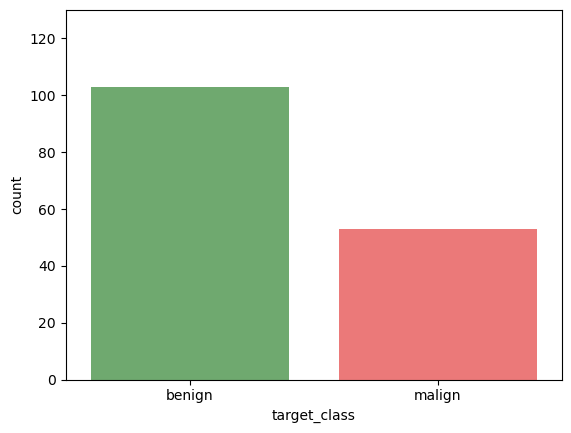

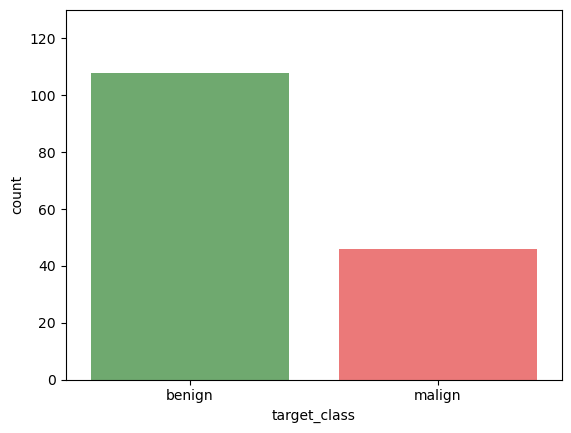

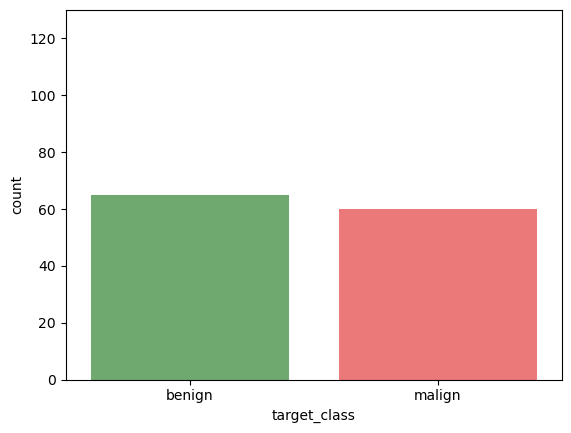

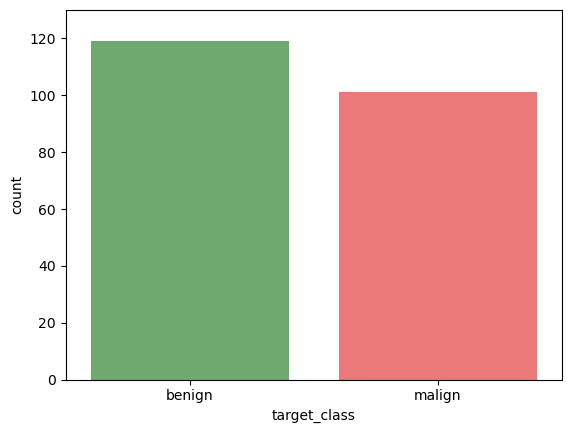

In [24]:
#| label: fig-dist-class
#| fig-cap: "Target class distribution in cohorts"
#| fig-subcap: 
#|   - "French cohort"
#|   - "Austrian cohort"
#|   - "German cohort"
#|   - "Italian cohort"
#| layout-ncol: 2
for country in ['france','austria','germany','italy']:
    plt.figure()
    
    # Get country specific dataset
    dataset = get_country_dataset('Nine_CRC_cohorts_taxon_profiles.tsv',country,country_dataset_mapping)

    # Plot class ditribution
    sns.countplot(data=dataset, x='target_class',alpha=.6,order=['benign','malign'],palette={'benign':'green','malign':'red'})
    plt.ylim([0,130])
    plt.show()

## Train and test split of dataset
We will split each of aforementioned cohort using **70/30 split rule** resulting in a training set of 70% cases and a test set of 30% cases. We will use the test set only for our final evaluation of our models' performance. 

In [9]:
from sklearn.model_selection import train_test_split

train_X_data = []
test_X_data = []

for country in ['france','austria','germany','italy']:
    # Get country specific dataset
    dataset = get_country_dataset('Nine_CRC_cohorts_taxon_profiles.tsv',country,country_dataset_mapping)

    y = dataset['target_class']
    X = dataset.copy()
    
    # Split train and test
    train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.20, random_state=42)
    
    # Storing train and test seperately
    train_X_data.append(train_x)
    test_X_data.append(test_x)
    
# Concatenating all country's dataset
train_X_df = pd.concat(train_X_data, axis=0)
test_X_df = pd.concat(test_X_data, axis=0)

# Preparing X and y
train_X = train_X_df.drop(['target_class'], axis=1)
train_y = train_X_df['target_class']

## Feature selection

Our dataset has **699** bacterial species or features for our modeling task. That is a large number of features, especially given our relatively small number of cases

We will employ different methods for feature selection to proceed with a smaller set of features which will allow an easier interpretation of resultant model and importance of features towards CRC classification.

### Relative abundance filtering
The first filtering technique simply discard features based on relative abundance data. We will discard any bacteria species whose maximum value do not exceeds .001 in any cohort dataest.


In [10]:
# fetching names of columns with abundance exceeding .001

# getting relative abundance data at species level
microbiome = aggregate_by_taxonomy(train_X_df, 'species')

# metadata
metadata = get_metadata(train_X_df)

# species with maximum value exceeding .01
columns_to_fetch = microbiome.columns[microbiome.max(axis=0) > 0.01]

## Pipeline building

The below diagram depicts our model building pipeline.

```{mermaid}

graph TD
    A[Input Data] --> B1[Filter Relative Abundance Data]
    B1 --> C1[Feature Selection]
    A --> B2[Compute Alpha Diversity]
    A --> B3[Impute Missing Metadata Features]
    C1 --> D[Combine Features]
    B2 --> D
    B3 --> D
    D --> E[Train ML Model with Nested CV]
    E --> F[Leave-One-Group-Out CV]
    E --> G[5-Fold Stratified CV]
    F --> H[Model Selection]
    G --> H[Model Selection]
```

In [121]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE, SelectKBest, SelectFpr, f_classif
from sklearn.linear_model import LogisticRegression


class DropFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Custom selector based of feature names for pipeline
    """
    def __init__(self, variables):
        self.variables = variables
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X_dropped = X.drop(self.variables, axis=1)
        return X_dropped
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Custom selector based of feature names for pipeline
    """
    def __init__(self, variables):
        self.variables = variables
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X_dropped = X[self.variables]
        return X_dropped
    
    
class RelativeAbundanceSelector(BaseEstimator, TransformerMixin):
    """
    Custom selector based on relative abundance filtering
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_select = X.columns[X.max(axis=0) > self.threshold]
        X_selected = X[columns_to_select]
        return X_selected
    
    
class BestFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Select top k features based on specified strategy
    """
    def __init__(self, estimator=LogisticRegression(), strategy='SelectKBest', n_features=30):
        self.strategy = strategy
        self.estimator = estimator
        self.n_features = n_features
        self.strategy_options = {'rfe':RFE(self.estimator, 
                                           n_features_to_select=self.n_features),
                                 'SelectKBest':SelectKBest(f_classif, k=self.n_features)}
        self.feature_names_out = None
        self.feature_selector = self.strategy_options[self.strategy]
        
    def fit(self, X, y=None):
        self.feature_selector.fit(X,y)
        self.feature_names_out = self.feature_selector.get_feature_names_out()
        return self
    
    def transform(self, X):
        X_selected = self.feature_selector.transform(X)
        df = pd.DataFrame(X_selected, columns=self.feature_names_out)
        
        return df
    
        
class AlphaFeatureExtender(BaseEstimator, TransformerMixin):
    """
    Custom transformer to extend relative abundace data with alpha diversity measure
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create an empty dataframe
        diversity_measures = pd.DataFrame()

        # alpha diversty measures
        alpha_diversity_metrics = [
            "chao1",
            "shannon",
            "simpson",
            "simpson_e",
            "fisher_alpha",
            "berger_parker"
        ]

        # Compute alpha diversity measures
        shannon_diversity = X.apply(lambda x: alpha.shannon(x), axis=1)
        chao1_diversity   = X.apply(lambda x: alpha.chao1(x), axis=1)
        simpson_diversity   = X.apply(lambda x: alpha.simpson(x), axis=1)
        simpson_e_diversity   = X.apply(lambda x: alpha.simpson_e(x), axis=1)
        fisher_diversity   = X.apply(lambda x: alpha.fisher_alpha(x), axis=1)
        berger_parker_diversity   = X.apply(lambda x: alpha.berger_parker_d(x), axis=1)

        # Add alpha measures to the dataframe
        diversity_measures['shannon'] = shannon_diversity
        diversity_measures['chao1'] = chao1_diversity
        diversity_measures['simpson'] = simpson_diversity
        diversity_measures['simpson_e'] = simpson_e_diversity
        diversity_measures['fisher_alpha'] = fisher_diversity
        diversity_measures['berger_parker'] = berger_parker_diversity

        return diversity_measures

class MetaDataImputer(BaseEstimator, TransformerMixin):
    """
    Imputer for specific metadata (i.e., age, genger, BMI)
    """
    def __init__(self):
        self.fill_values = dict()

    
    def fit(self, X, y=None):
        X['age'] = pd.to_numeric(X['age'], errors='coerce')
        X['BMI'] = pd.to_numeric(X['BMI'], errors='coerce')
        
        self.fill_values['age'] = X['age'].mean()
        self.fill_values['BMI'] = X['BMI'].mean()
        self.fill_values['gender'] = X['gender'].mode().values[0]
        return self
    
    def transform(self, X):
        X['age'] = pd.to_numeric(X['age'], errors='coerce')
        X['BMI'] = pd.to_numeric(X['BMI'], errors='coerce')
        
        for col in X.columns:
            X[col].fillna(self.fill_values[col], inplace=True)
        X['gender'] = X['gender'].map({'female':0, 'male':1})
        return X

In [93]:
'  pankaj. '.strip()

'pankaj.'

In [94]:
species_colnames = [get_specific_label(item.strip(), 'species') for item in bacteria_colnames]

In [30]:
meta = train_X_df[['age','gender','BMI']]

train_X_df['age'] = pd.to_numeric(train_X_df['age'], errors='coerce')
train_X_df['BMI'] = pd.to_numeric(train_X_df['BMI'], errors='coerce')

In [122]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Pipeline for species selection using relative abundace data
abundance_processing = Pipeline([
    ('abundance_columns', ColumnSelector(species_colnames)),
    ('abundance_filter', RelativeAbundanceSelector(threshold=.001)),
    ('species_selector', BestFeatureSelector())
])

# Pipeline for computing alpha diversity
alpha_processing = Pipeline([
    ('abundance_columns', ColumnSelector(species_colnames)),
    ('alpha_extended', AlphaFeatureExtender())
])

# Pipeline for imputing metadata
meta_processing = Pipeline([
    ('meta_columns', ColumnSelector(['age','BMI','gender'])),
    ('meta_imputer', MetaDataImputer())
])

# Concatenating results 
combined_features = FeatureUnion([
    ('abun_part', abundance_processing),
    ('alpha_part', alpha_processing),
    ('meta_part', meta_processing)
])
     

In [124]:
combined_features

FeatureUnion(transformer_list=[('abun_part',
                                Pipeline(steps=[('abundance_columns',
                                                 ColumnSelector(variables=['Granulicella_unclassified',
                                                                           'Actinobaculum_massiliense',
                                                                           'Actinobaculum_schaalii',
                                                                           'Actinobaculum_unclassified',
                                                                           'Actinomyces_cardiffensis',
                                                                           'Actinomyces_europaeus',
                                                                           'Actinomyces_graevenitzii',
                                                                           'Actinomyces_johnsonii',
                                                                           'Actinomyces_massiliensis',
                                                                           'Act...
                                                                           'Brevibacterium_massiliense',
                                                                           'Brevibacterium_unclassified',
                                                                           'Corynebacterium_amycolatum',
                                                                           'Corynebacterium_aurimucosum',
                                                                           'Corynebacterium_casei',
                                                                           'Corynebacterium_crenatum', ...])),
                                                ('alpha_extended',
                                                 AlphaFeatureExtender())])),
                               ('meta_part',
                                Pipeline(steps=[('meta_columns',
                                                 ColumnSelector(variables=['age',
                                                                           'BMI',
                                                                           'gender'])),
                                                ('meta_imputer',
                                                 MetaDataImputer())]))])

In [109]:
comb = combined_features.fit(train_X_df_species, y)

In [108]:
train_X_df_species = train_X_df.copy()

new_cols = []

for col in train_X_df_species.columns:
    if 'k__' in col:
        new_cols.append(get_specific_label(col.strip(), 'species'))
        train_X_df_species[col] = train_X_df_species[col].astype('float32')
    else:
        new_cols.append(col)
        
train_X_df_species.columns = new_cols

In [114]:
comb.transform(train_X_df_species)s

,Bacteroides_caccae,Bacteroides_fragilis,Bacteroides_nordii,Odoribacter_splanchnicus,Gemella_morbillorum,Eubacterium_rectale,Peptostreptococcus_stomatis,Solobacterium_moorei,Fusobacterium_nucleatum,Unknown,...,Unknown,shannon,chao1,simpson,simpson_e,fisher_alpha,berger_parker,age,BMI,gender
57,1.23965,8.12859,0.00000,0.19296,1.31243,3.966190,1.00263,3.02131,0.96822,0.0,...,0.0,3.147702,146.0,0.905238,0.072279,4.427762e+09,0.260678,70.000000,26.000000,0
139,3.27993,0.26902,0.00077,0.13175,0.00000,7.124360,0.08430,0.12188,0.00000,0.0,...,0.0,3.383702,127.0,0.949820,0.156915,1.608697e+09,0.097682,62.000000,26.000000,1
124,0.00000,0.00545,0.00541,1.41066,0.00000,0.008600,0.00000,0.00285,0.00000,0.0,...,0.0,2.928985,116.0,0.908311,0.094021,7.015319e+09,0.216074,62.000000,20.000000,0
129,0.30372,0.38415,0.00000,0.00000,0.00000,12.817680,0.00000,0.00000,0.00000,0.0,...,0.0,2.811771,71.0,0.888355,0.126155,1.095090e+02,0.208386,38.000000,22.000000,0
128,0.00000,0.87623,0.00247,0.51210,0.00000,0.000000,0.00000,0.00000,0.00000,0.0,...,0.0,2.998262,94.0,0.894006,0.100367,7.683948e+02,0.283679,64.000000,30.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,0.66694,0.00000,0.00000,0.00000,0.00000,20.053301,0.00000,0.00000,0.00000,0.0,...,0.0,2.980789,93.0,0.910226,0.119775,6.484124e+02,0.200533,51.000000,19.433013,0
639,2.11702,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.0,...,0.0,2.001838,63.0,0.716683,0.056026,7.294689e+01,0.503216,77.000000,23.000000,1
730,0.00000,0.00000,0.00000,0.00000,0.00000,8.948760,0.00000,0.00000,0.00000,0.0,...,0.0,3.374095,84.0,0.951956,0.247789,2.476911e+02,0.096141,54.000000,25.180785,1
817,5.04852,0.00000,0.01660,0.84033,0.00000,12.597370,0.00000,0.00000,0.00000,0.0,...,0.0,3.174927,83.0,0.939201,0.198164,2.294836e+02,0.125979,63.639738,19.151192,1


In [116]:
comb

AttributeError: 'MetaDataImputer' object has no attribute 'values'

AttributeError: 'MetaDataImputer' object has no attribute 'values'

AttributeError: 'MetaDataImputer' object has no attribute 'values'